# Radon transforms

The aim of this notebook is to show how to use the ChirpRadon2D and ChirpRadon3D implementations in Pylops.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pyfftw
import pylops

from pylops.basicoperators import FunctionOperator
from pylops.signalprocessing import *
from pylops.utils import dottest

from pylops.signalprocessing._ChirpRadon2D import _chirp_radon_2d                   
from pylops.signalprocessing._ChirpRadon3D import _chirp_radon_3d, _chirp_radon_3d_fftw
from pylops.signalprocessing._ChirpRadon3D import *

from pylops.signalprocessing.ChirpRadon2D import ChirpRadon2D
from pylops.signalprocessing.ChirpRadon3D import ChirpRadon3D

## 2D

In [2]:
# Create axis
par = {'ot': 0,    'dt': 0.004, 'nt': 51,
       'ox': -250, 'dx': 10, 'nx': 51,
       'oy': -250, 'dy': 10, 'ny': 51,
       'f0': 40}
theta = [20, ]
t0 = [0.1, ]
amp = [1., ]

# Create axis
t, t2, x, y = pylops.utils.seismicevents.makeaxis(par)
dt, dx, dy = par['dt'], par['dx'], par['dy']

# Create wavelet
wav, _, wav_c = pylops.utils.wavelets.ricker(t[:41], f0=par['f0'])

# Generate model
_, d = \
    pylops.utils.seismicevents.linear2d(x, t, 1500., t0, theta, amp, wav)

In [3]:
npx, pxmax = par['nx'], 5e-4
px = np.linspace(-pxmax, pxmax, npx)

#dL_chirp = _chirp_radon_2d(d, dt, dx, pxmax*dx/dt, mode='f')
#dadj_chirp = _chirp_radon_2d(dL_chirp, dt, dx, pxmax*dx/dt, mode='a')
#dinv_chirp = _chirp_radon_2d(dL_chirp, dt, dx, pxmax*dx/dt, mode='i')

R2Op = ChirpRadon2D(t, x, pxmax*dx/dt, dtype='float64')
dL_chirp = R2Op * d.ravel()
dadj_chirp = R2Op.H * dL_chirp
dinv_chirp = R2Op.inverse(dL_chirp)

dL_chirp = dL_chirp.reshape(par['nx'], par['nt'])
dadj_chirp = dadj_chirp.reshape(par['nx'], par['nt'])
dinv_chirp = dinv_chirp.reshape(par['nx'], par['nt'])

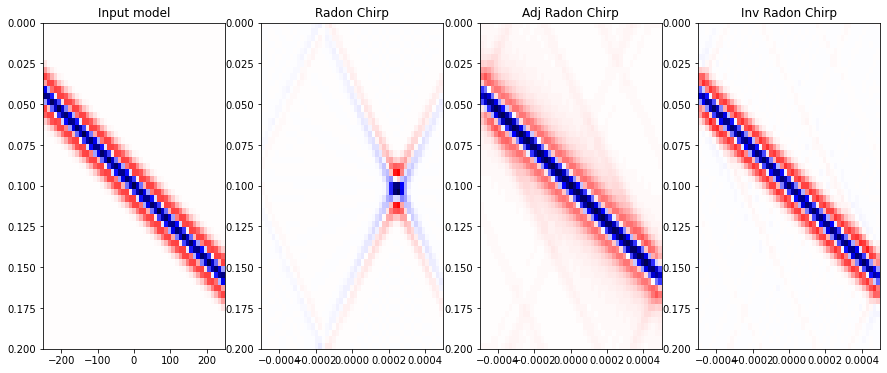

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
axs[0].imshow(d.T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow(dL_chirp.T, cmap='seismic_r', vmin=-dL_chirp.max(), vmax=dL_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].set_title('Radon Chirp')
axs[1].axis('tight')
axs[2].imshow(dadj_chirp.T, cmap='seismic_r', vmin=-dadj_chirp.max(), vmax=dadj_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon Chirp')
axs[2].axis('tight')
axs[3].imshow(dinv_chirp.T, cmap='seismic_r', vmin=-d.max(), vmax=d.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[3].set_title('Inv Radon Chirp')
axs[3].axis('tight');

Test operator

In [5]:
dottest(R2Op, R2Op.shape[0], R2Op.shape[1], tol=1e-4, verb=True)

Dot test passed, v^T(Opu)=137.528846 - u^T(Op^Tv)=137.528846


True

## 3D

In [6]:
#par = {'ot': 0,    'dt': 0.004, 'nt': 201,
#       'ox': -625, 'dx': 12.5, 'nx': 101,
#       'oy': -625, 'dy': 12.5, 'ny': 101,
#       'f0': 20}
#theta = [0, ]
#t0 = [0.5, ]
#amp = [1., ]

# Create axis
par = {'ot': 0,    'dt': 0.004, 'nt': 51,
       'ox': -250, 'dx': 10, 'nx': 51,
       'oy': -250, 'dy': 10, 'ny': 51,
       'f0': 40}
theta = [20, ]
t0 = [0.1, ]
amp = [1., ]

# Create axis
t, t2, x, y = pylops.utils.seismicevents.makeaxis(par)
dt, dx, dy = par['dt'], par['dx'], par['dy']

# Create wavelet
wav = pylops.utils.wavelets.ricker(t[:41], f0=par['f0'])[0]

# Generate model
_, d = \
    pylops.utils.seismicevents.linear3d(x, y, t, 1500., t0, theta, [0, ], amp, wav)

Adjoint (from data to slantstack)

In [7]:
npy, pymax = par['ny'], 5e-4
npx, pxmax = par['nx'], 5e-4

py = np.linspace(-pymax, pymax, npy)
px = np.linspace(-pxmax, pxmax, npx)


dL_chirp = _chirp_radon_3d(d, dt, dx, dy, (pxmax*dx/dt, pymax*dy/dt))
dL_chirp1 = _chirp_radon_3d_fftw(d, dt, dx, dy, (pxmax*dx/dt, pymax*dy/dt), 
                                **dict(flags=('FFTW_ESTIMATE', ), threads=2))

Forward (from slantstack to data)

In [8]:
dadj_chirp = _chirp_radon_3d(dL_chirp, dt, dx, dy, (pxmax*dx/dt, pymax*dy/dt), mode='a')
dadj_chirp1 = _chirp_radon_3d_fftw(dL_chirp1, dt, dx, dy, (pxmax*dx/dt, pymax*dy/dt), mode='a', 
                                  **dict(flags=('FFTW_ESTIMATE', ), threads=2))

Inverse

In [9]:
dinv_chirp = _chirp_radon_3d(dL_chirp, dt, dx, dy, (pxmax*dx/dt, pymax*dy/dt), mode='i')
dinv_chirp1 = _chirp_radon_3d_fftw(dL_chirp1, dt, dx, dy, (pxmax*dx/dt, pymax*dy/dt), mode='i', 
                                  **dict(flags=('FFTW_ESTIMATE', ), threads=2))

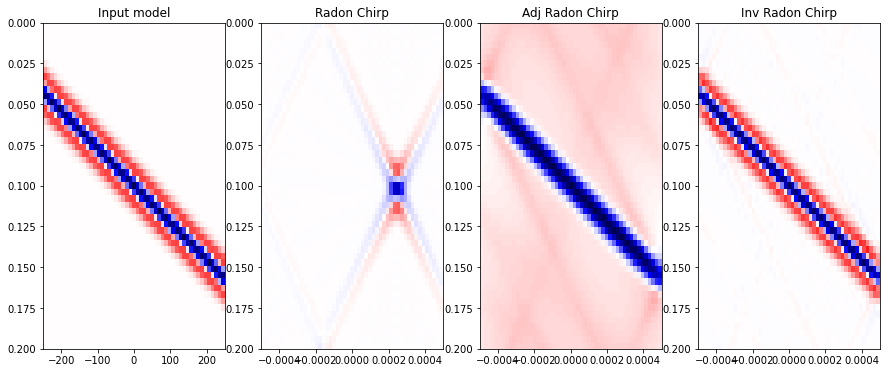

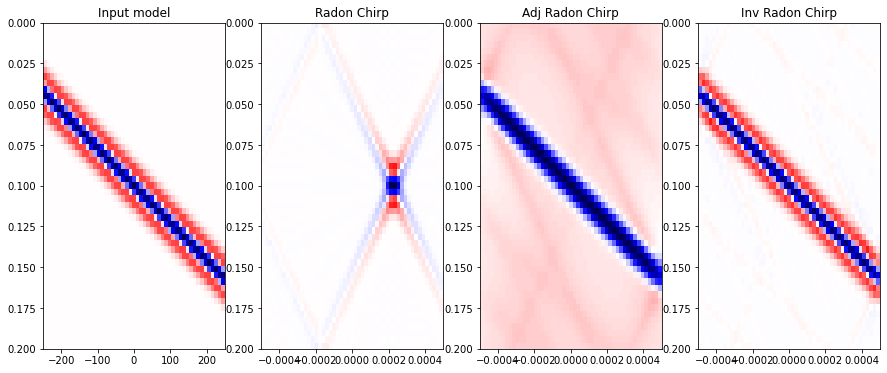

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
axs[0].imshow(d[par['ny']//2].T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow(dL_chirp[npy//2].T, cmap='seismic_r', vmin=-dL_chirp.max(), vmax=dL_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].set_title('Radon Chirp')
axs[1].axis('tight')
axs[2].imshow(dadj_chirp[npy//2].T, cmap='seismic_r', vmin=-dadj_chirp.max(), vmax=dadj_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon Chirp')
axs[2].axis('tight')
axs[3].imshow(dinv_chirp[npy//2].T, cmap='seismic_r', vmin=-d.max(), vmax=d.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[3].set_title('Inv Radon Chirp')
axs[3].axis('tight');

fig, axs = plt.subplots(1, 4, figsize=(15, 6))
axs[0].imshow(d[par['ny']//2].T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow(dL_chirp1[npy//2].T, cmap='seismic_r', vmin=-dL_chirp.max(), vmax=dL_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].set_title('Radon Chirp')
axs[1].axis('tight')
axs[2].imshow(dadj_chirp1[npy//2].T, cmap='seismic_r', vmin=-dadj_chirp.max(), vmax=dadj_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon Chirp')
axs[2].axis('tight')
axs[3].imshow(dinv_chirp1[npy//2].T, cmap='seismic_r', vmin=-d.max(), vmax=d.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[3].set_title('Inv Radon Chirp')
axs[3].axis('tight');

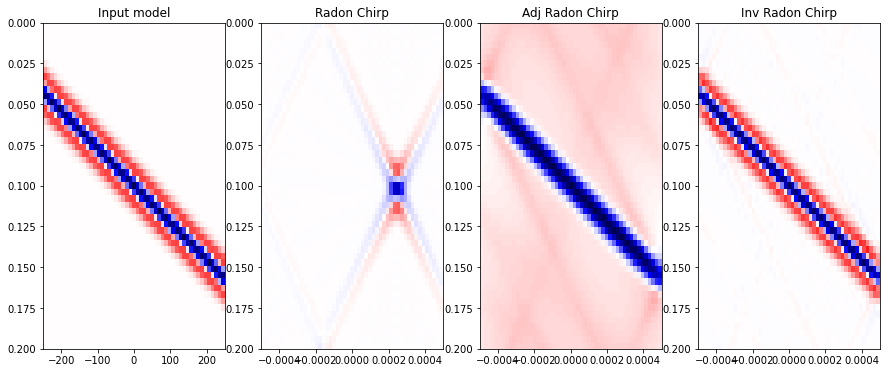

In [11]:
R3Op = ChirpRadon3D(t, y, x, (pymax*dy/dt, pxmax*dx/dt), dtype='float64')

dL_chirp = R3Op * d.ravel()
dadj_chirp = R3Op.H * dL_chirp
dinv_chirp = R3Op.inverse(dL_chirp)

dL_chirp = dL_chirp.reshape(par['ny'], par['nx'], par['nt'])
dadj_chirp = dadj_chirp.reshape(par['ny'], par['nx'], par['nt'])
dinv_chirp = dinv_chirp.reshape(par['ny'], par['nx'], par['nt'])

fig, axs = plt.subplots(1, 4, figsize=(15, 6))
axs[0].imshow(d[par['ny']//2].T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow(dL_chirp[npy//2].T, cmap='seismic_r', vmin=-dL_chirp.max(), vmax=dL_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].set_title('Radon Chirp')
axs[1].axis('tight')
axs[2].imshow(dadj_chirp[npy//2].T, cmap='seismic_r', vmin=-dadj_chirp.max(), vmax=dadj_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon Chirp')
axs[2].axis('tight')
axs[3].imshow(dinv_chirp[npy//2].T, cmap='seismic_r', vmin=-d.max(), vmax=d.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[3].set_title('Inv Radon Chirp')
axs[3].axis('tight');

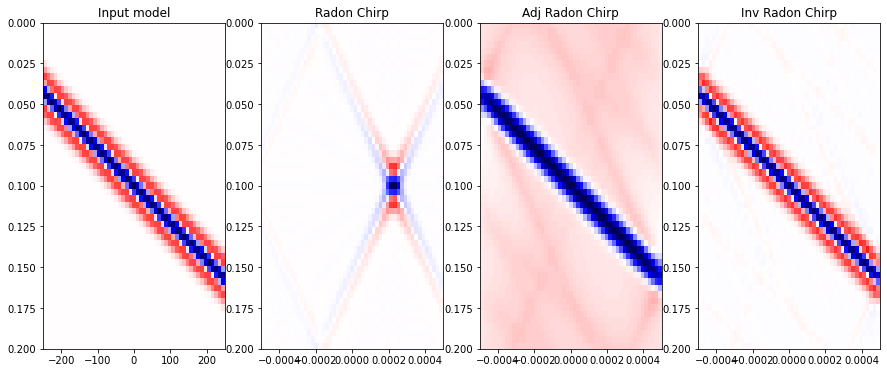

In [12]:
R3Opfftw = ChirpRadon3D(t, y, x, (pymax*dy/dt, pxmax*dx/dt), dtype='float64', engine='fftw',
                    **dict(flags=('FFTW_ESTIMATE', ), threads=2))
dL_chirp = R3Opfftw * d.ravel()
dadj_chirp = R3Opfftw.H * dL_chirp
dinv_chirp = R3Opfftw.inverse(dL_chirp)

dL_chirp = dL_chirp.reshape(par['ny'], par['nx'], par['nt'])
dadj_chirp = dadj_chirp.reshape(par['ny'], par['nx'], par['nt'])
dinv_chirp = dinv_chirp.reshape(par['ny'], par['nx'], par['nt'])

fig, axs = plt.subplots(1, 4, figsize=(15, 6))
axs[0].imshow(d[par['ny']//2].T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow(dL_chirp[npy//2].T, cmap='seismic_r', vmin=-dL_chirp.max(), vmax=dL_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].set_title('Radon Chirp')
axs[1].axis('tight')
axs[2].imshow(dadj_chirp[npy//2].T, cmap='seismic_r', vmin=-dadj_chirp.max(), vmax=dadj_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon Chirp')
axs[2].axis('tight')
axs[3].imshow(dinv_chirp[npy//2].T, cmap='seismic_r', vmin=-d.max(), vmax=d.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[3].set_title('Inv Radon Chirp')
axs[3].axis('tight');

Test operator

In [13]:
dottest(R3Op, R3Op.shape[0], R3Op.shape[1], verb=True);
dottest(R3Opfftw, R3Opfftw.shape[0], R3Opfftw.shape[1], verb=True);

Dot test passed, v^T(Opu)=19244.529201 - u^T(Op^Tv)=19244.529201
Dot test passed, v^T(Opu)=-32509.383070 - u^T(Op^Tv)=-32509.383070


In [14]:
%timeit -n4 -r 2 R3Op * d.ravel()
%timeit -n4 -r 2 R3Opfftw * d.ravel()

166 ms ± 27.5 ms per loop (mean ± std. dev. of 2 runs, 4 loops each)
77.3 ms ± 624 µs per loop (mean ± std. dev. of 2 runs, 4 loops each)
